In [108]:
!pip install -U scipy==1.2.0

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Importamos todas las librerias
import time
from __future__ import print_function
from PIL import Image
import numpy as np
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
import imageio
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.gridspec as gridspec

In [0]:
#Tenemos que lograr que nuestra imagen input sea cruadrada

def squareImage(inputImage):
  #Para ello vamos a leer sus dimensiones
  widthInput, heightInput = inputImage.size
  #print(widthInput,heightInput)

  #Declaracion de variables
  left=0
  right=0
  up=0
  down=0
  difWH=0
  cropDif=0

  #Hay que validar cual es el mayor para saber cual hay que cortar
  if widthInput>heightInput:

    #Se debe tomar la diferencia porque significa que es el sobrante
    difWH=widthInput-heightInput

    #Ahora se debe dividir la diferencia en 2 para tomar el recorte
    cropDif=difWH/2
    
    #Al ser el ancho el mas largo, tanto derecha como izquierda se deben recortar
    left=cropDif
    right=widthInput-cropDif
    up=0
    down=heightInput

  else:

    #Se debe tomar la diferencia porque significa que es el sobrante
    difWH=heightInput-widthInput

    #Ahora se debe dividir la diferencia en 2 para tomar el recorte
    cropDif=difWH/2
    
    #Al ser el Alto el mas largo, tanto Arriba como Abajo se deben recortar
    left=0
    right=widthInput
    up=cropDif
    down=cropDif


  #Los parametros del crop son (Izquierda,Arriba,Derecha,Abajo) en pixeles
  cropRegion=(left,up,right,down)
  print(cropRegion)
  inputImageCrop=inputImage.crop(cropRegion)

  #Retornamos resultado
  return inputImageCrop



In [160]:
#Cargamos Imagenes de entrada como la del Estilo

inputI='Alexis'
style='Art8'

#Seteamos Rutas
inputImgPath='/content/drive/My Drive/DS: Hands off/Manipulate Images/Style Transfer/Raw Images/'+inputI+'.jpeg'
styleImgPath='/content/drive/My Drive/DS: Hands off/Manipulate Images/Style Transfer/Styles/'+style+'.jpg'


inputImage=Image.open(inputImgPath)
styleImage=Image.open(styleImgPath)

inputImageCrop = squareImage(inputImage)

(49.0, 0, 1231.0, 1182)


In [0]:
 def img_iteration(it,content_image,style_image):
  ##Usamos el script que me paso juan
  content_array = np.asarray(content_image, dtype= 'float32')
  content_array = np.expand_dims(content_array, axis=0)
  print(content_array.shape)

  style_array = np.asarray(style_image, dtype= 'float32')
  style_array = np.expand_dims(style_array, axis=0)
  print(style_array.shape)

  content_array[:, :, :, 0] -= 103.939
  content_array[:, :, :, 1] -= 116.779
  content_array[:, :, :, 2] -= 123.68
  content_array = content_array[:, :, :, ::-1]

  style_array[:, :, :, 0] -= 103.939
  style_array[:, :, :, 1] -= 116.779
  style_array[:, :, :, 2] -= 123.68
  style_array = style_array[:, :, :, ::-1]

  content_image = backend.variable(content_array)
  style_image = backend.variable(style_array)
  combination_image = backend.placeholder((1, height, width, 3))

  input_tensor = backend.concatenate([content_image, style_image, combination_image], axis = 0)

  model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top = False)

  layers = dict([(layer.name, layer.output) for layer in model.layers])

  content_weight = 0.025
  style_weight = 5.0
  total_variation_weight = 1.0

  loss = backend.variable(0.)

  def content_loss(content, combination):
      return backend.sum(backend.square(combination - content))

  layer_features = layers['block2_conv2']
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = loss + content_weight * content_loss(content_image_features, combination_features)

  def gram_matrix(x):
      features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
      gram = backend.dot(features, backend.transpose(features))
      return gram

  def style_loss(style, combination):
      S = gram_matrix(style)
      C = gram_matrix(combination)
      channels = 3
      size = height * width
      return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

  feature_layers = ['block1_conv2', 'block2_conv2', 
                    'block3_conv3', 'block4_conv3', 
                    'block5_conv3']

  for layer_name in feature_layers:
      layer_features = layers[layer_name]
      style_features = layer_features[1, : ,: ,:]
      combination_features = layer_features[2, :, :, :]
      sl = style_loss(style_features, combination_features)
      loss += (style_weight / len(feature_layers)) * sl
      
  def total_variation_loss(x):
      a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
      b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
      return backend.sum(backend.pow(a + b, 1.25))

  loss += total_variation_weight * total_variation_loss(combination_image)

  grads = backend.gradients(loss, combination_image)

  outputs = [loss]
  outputs += grads
  f_outputs = backend.function([combination_image], outputs)

  def eval_loss_and_grads(x):
      x = x.reshape((1, height, width, 3))
      outs = f_outputs([x])
      loss_value = outs[0]
      grad_values = outs[1].flatten().astype('float64')
      return loss_value, grad_values

  class Evaluator(object):

      def __init__(self):
          self.loss_value = None
          self.grads_values = None

      def loss(self, x):
          assert self.loss_value is None
          loss_value, grad_values = eval_loss_and_grads(x)
          self.loss_value = loss_value
          self.grad_values = grad_values
          return self.loss_value

      def grads(self, x):
          assert self.loss_value is not None
          grad_values = np.copy(self.grad_values)
          self.loss_value = None
          self.grad_values = None
          return grad_values

  evaluator = Evaluator()

  x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

  iterations = it

  for i in range(iterations):
      #print('Start of iteration', i)
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                      fprime=evaluator.grads, maxfun = 20)
      #print('Current loss value:', min_val)
      end_time = time.time()
      #print('Iteration %d completed in %ds' % (i, end_time - start_time))

  x = x.reshape((height, width, 3))
  x = x[:, :, ::-1]
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = np.clip(x, 0, 255).astype('uint8')

  Image.fromarray(x)


  imageio.imwrite('/content/drive/My Drive/DS: Hands off/Manipulate Images/Style Transfer/Final Images/'+inputI+'-'+style+str(i+1)+'.jpg', x)
  return x
  # result_img(x)
  #plt.imshow(x)
  # plt.show()



In [0]:
#Llevamos al mismo tamaño ambas imagenes
#width,height=inputImageCrop.size
width,height=512,512
content_image=inputImageCrop.resize((width,height))
style_image=styleImage.resize((width,height))

In [0]:
def inputs_images(fig):
  ax1=fig.add_subplot(1, 2, 1)
  ax1.title.set_text('Input Image')
  plt.imshow(content_image)
  ax2=fig.add_subplot(1, 2, 2)
  ax2.title.set_text('Style Image')
  plt.imshow(style_image)
  plt.show()

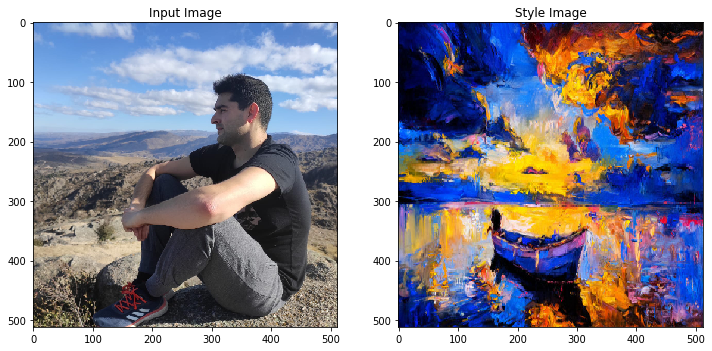

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


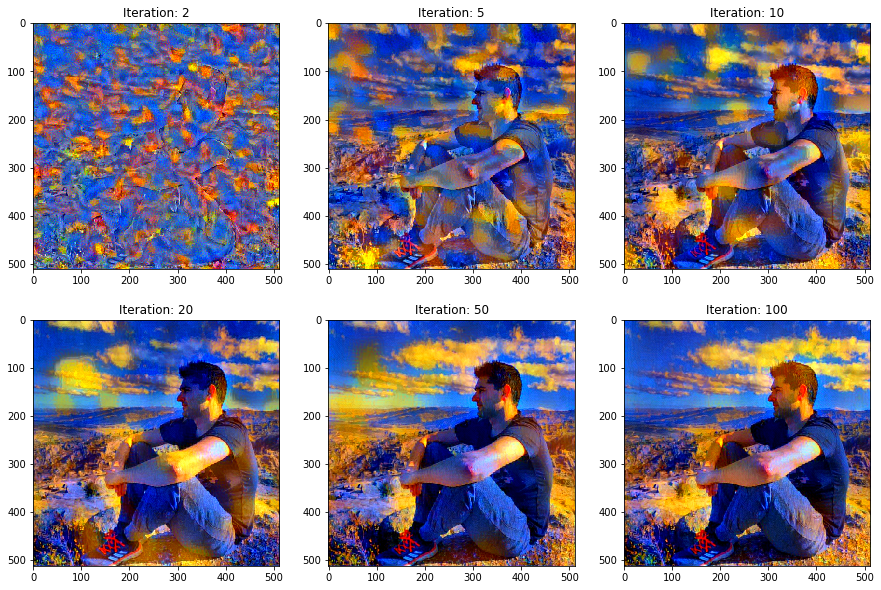

In [165]:
it_array=[2,5,10,20,50,100]
i=1
fig=plt.figure(figsize=(12, 12))
inputs_images(fig)
fig2=plt2.figure(figsize=(15,10))
fig2.subplots_adjust(hspace=0.2, wspace=0.2)

for itera in it_array:

  ##Capturamos y ploteamos la imgen de Salidad
  img_out=img_iteration(itera,content_image,style_image)
  axi=fig2.add_subplot(2, 3, i)
  axi.title.set_text('Iteration: '+str(itera))
  plt2.imshow(img_out)
  i+=1
plt2.show()